# Проект: Анализ бизнес-показателей.

<b> Описание проекта: </b>

Задача проекта проанализировать работу развлекательного приложения Procrastinate Pro+ в период с 1 мая по 27 октября 2019 года.

<b> Необходимо изучить: </b> 

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

<b> Ход исследования: </b> 
- Подготовим данные к анализу.
- Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.
- Проведём исследовательский анализ данных.
- Исследуем показатели маркетинга.
- Оценим окупаемость рекламы.

<b> Описание данных: </b>

В нашем распоряжении три датасета: 

- Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, 
- orders_info_short.csv — информацию о заказах, 
- costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:

- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:

- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:

- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

### Подготовка данных к анализу.

#### Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [8]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [9]:
orders = pd.read_csv('/datasets/orders_info_short.csv')
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [10]:
costs = pd.read_csv('/datasets/costs_info_short.csv')
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Приведём название столбцов к snake_case.

In [11]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

#### Изучим данные и выполним предобработку. 

Проверим, есть ли в данных пропуски и дубликаты. Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. 

##### Найдём пропуски и дубликаты.

In [12]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [13]:
visits.duplicated().sum()

0

In [14]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [15]:
orders.duplicated().sum()

0

In [16]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

In [17]:
costs.duplicated().sum()

0

Пропуски и дубликаты отсутствуют.

##### Проверим типы данных.

In [18]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [20]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Преобразуем данные о времени к соответствующему типу.

In [21]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Данные подготовлены к анализу.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция `get_profiles()` — для создания профилей пользователей.

In [22]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция `get_retention()` — для подсчёта Retention Rate.

In [23]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция `get_conversion()` — для подсчёта конверсии.

In [24]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция `get_ltv()` — для подсчёта LTV.

In [25]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция `filter_data()` — для сглаживания данных.

In [26]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Функция `plot_retention()` — для построения графика Retention Rate.

In [27]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция `plot_conversion()` — для построения графика конверсии.

In [28]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция `plot_ltv_roi` — для визуализации LTV и ROI.

In [29]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функции для расчёта и анализа LTV, ROI, удержания и конверсии заданы.

### Исследовательский анализ данных.

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

#### Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [30]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [31]:
profiles['dt'].agg(['min', 'max'])

min    2019-05-01
max    2019-10-27
Name: dt, dtype: object

 <b> Вывод: </b>
 
 Минимальная дата привлечения пользователей - 01 мая 2019 года.
 
 Максимальная дата привлечения пользователей - 27 октября 2019 года.

#### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [32]:
t_all = pd.DataFrame(profiles.groupby('region')['user_id'].count())

t_payer = profiles[profiles['payer'] == True]
t_payer = pd.DataFrame(t_payer.groupby('region')['user_id'].count())

t_percent = t_payer / t_all * 100

t_payer_users = t_all.merge(t_percent, on='region', how='left').reset_index()
t_payer_users.columns = ['region', 'user_cnt', 'payer_percent']

t_payer_users

,region,user_cnt,payer_percent
0,France,17450,3.799427
1,Germany,14981,4.111875
2,UK,17575,3.982930
3,United States,100002,6.901862


 <b> Вывод: </b>
 
 Пользователи приходят из 4 стран: Франция, Германия, Великобритания, США.
 
 Больше всего платящих пользователей из США. 

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [33]:
t_all = pd.DataFrame(profiles.groupby('device')['user_id'].count())

t_payer = profiles[profiles['payer'] == True]
t_payer = pd.DataFrame(t_payer.groupby('device')['user_id'].count())

t_percent = t_payer / t_all * 100

t_payer_users = t_all.merge(t_percent, on='device', how='left').reset_index()
t_payer_users.columns = ['device', 'user_cnt', 'payer_percent']

t_payer_users

,device,user_cnt,payer_percent
0,Android,35032,5.851793
1,Mac,30042,6.364423
2,PC,30455,5.046790
3,iPhone,54479,6.207897


 <b> Вывод: </b>
 
 Пользователи используют 4 устройства: Android, Mac, PC, iPhone.
 
 Больше всего платящих пользователей используют Mac. 

#### Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [34]:
t_all = pd.DataFrame(profiles.groupby('channel')['user_id'].count())

t_payer = profiles[profiles['payer'] == True]
t_payer = pd.DataFrame(t_payer.groupby('channel')['user_id'].count())

t_percent = t_payer / t_all * 100

t_payer_users = t_all.merge(t_percent, on='channel', how='left').reset_index()
t_payer_users.columns = ['channel', 'user_cnt', 'payer_percent']

t_payer_users

,channel,user_cnt,payer_percent
0,AdNonSense,3880,11.340206
1,FaceBoom,29144,12.204914
2,LeapBob,8553,3.063253
3,MediaTornado,4364,3.574702
4,OppleCreativeMedia,8605,2.707728
5,RocketSuperAds,4448,7.913669
6,TipTop,19561,9.600736
7,WahooNetBanner,8553,5.296387
8,YRabbit,4312,3.826531
9,lambdaMediaAds,2149,10.469986


 <b> Вывод: </b>
 
Всего 11 каналов привлечения пользователей: AdNonSense, FaceBoom, LeapBob, MediaTornado, OppleCreativeMedia, RocketSuperAds, TipTop, WahooNetBanner, YRabbit, lambdaMediaAds, organic.
 
Больше всего платящих пользователей привлечены через FaceBoom. 

 <b> Общий вывод по исследовательскому анализу данных: </b>
 
По результатам исследовательского анализа данных можно составить портрет "идеального платящего пользователя". Такой пользователь проживает в США, использует Mac и посещает FaceBoom.

### Маркетинг.

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику, отразим это на одном графике.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

#### Посчитаем общую сумму расходов на маркетинг.

In [35]:
costs_sum = costs['costs'].sum().round()
costs_sum

105497.0

 <b> Вывод: </b>
 
 Общая сумма расходов на маркетинг составила 105497.30000000002.

#### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [36]:
costs['percent'] = costs['costs'] / costs_sum * 100

t_costs = costs.groupby('channel')[['costs', 'percent']].sum().sort_values(by='costs', ascending=False).reset_index().copy()
t_costs

,channel,costs,percent
0,TipTop,54751.30,51.898443
1,FaceBoom,32445.60,30.754998
2,WahooNetBanner,5151.00,4.882603
3,AdNonSense,3911.25,3.707451
4,OppleCreativeMedia,2151.25,2.039158
5,RocketSuperAds,1833.00,1.737490
6,LeapBob,1797.60,1.703935
7,lambdaMediaAds,1557.60,1.476440
8,MediaTornado,954.48,0.904746
9,YRabbit,944.22,0.895021


 <b> Вывод: </b>
 
 Больше всего трат пришлось на рекламные источники TipTop и FaceBoom.

#### Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику, отразим это на одном графике.

In [37]:
df = costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')

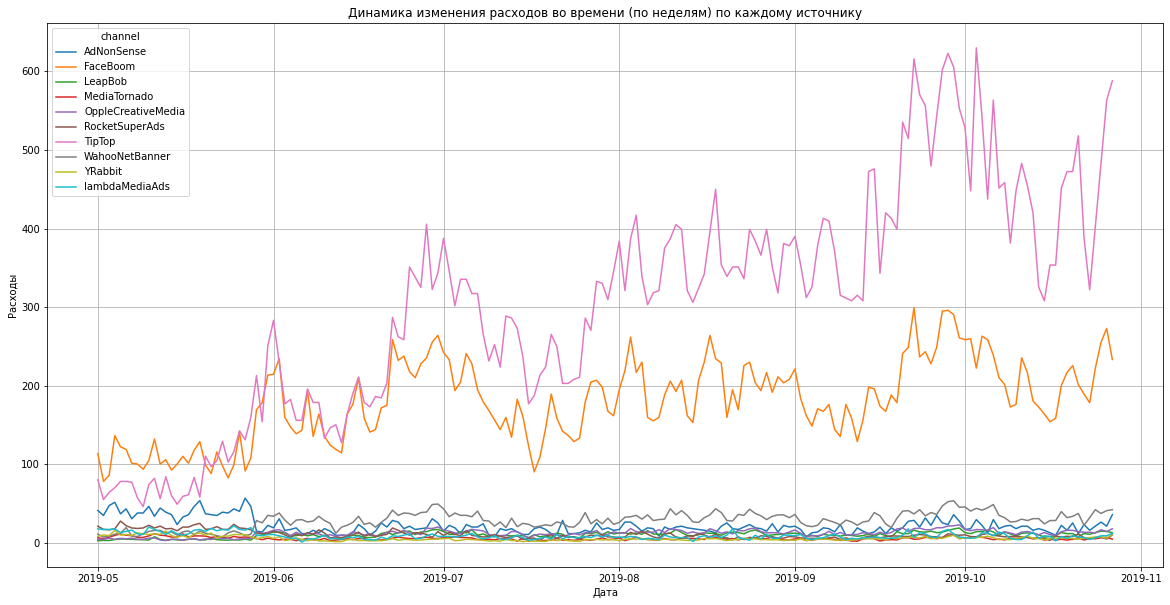

In [38]:
df.plot(grid=True, figsize=(20, 10))
plt.title('Динамика изменения расходов во времени (по неделям) по каждому источнику')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

In [39]:
costs['month'] = costs['dt'].astype('datetime64[M]')
df = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

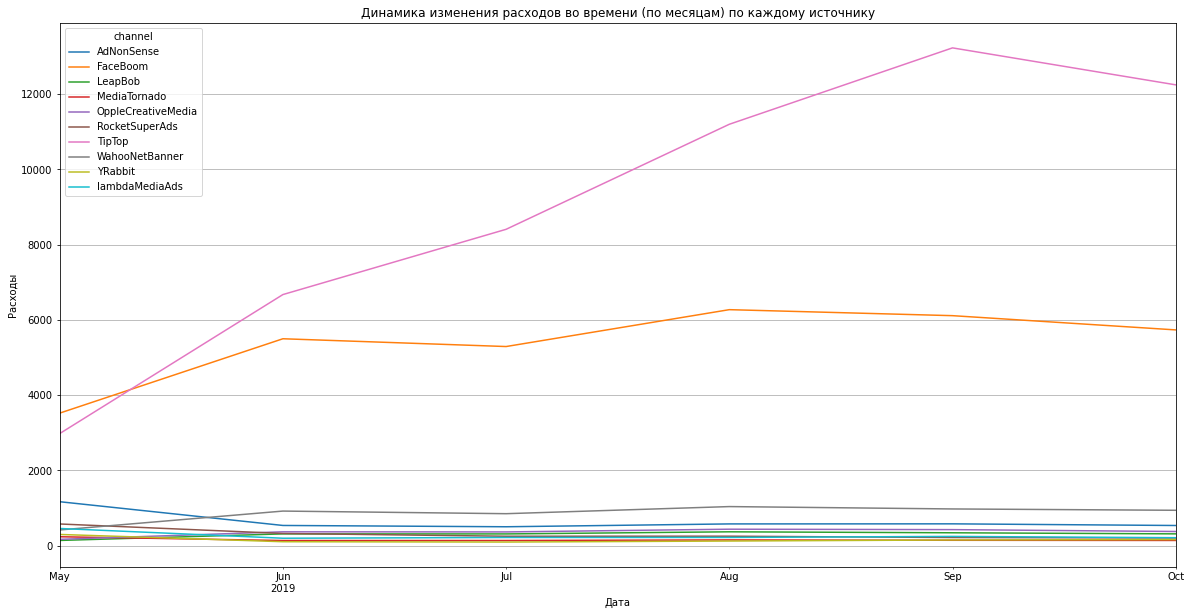

In [40]:
df.plot(grid=True, figsize=(20, 10))
plt.title('Динамика изменения расходов во времени (по месяцам) по каждому источнику')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

 <b> Вывод: </b>
 
За исследуемый период времени, с 1 мая по 27 октября 2019 года, расходы на TipTop заметно росли, хотя и имели местами спады, а расходы FaceBoom (второго по затратности источника) начиная с июня застряли в коридоре 100 - 300 (в недельном выражении).

Расходы на иные источники за весь период остаются в пределах 50 и в целом, данные расходы значительно меньше, чем расходы на  TipTop и FaceBoom.

#### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

In [41]:
mean_acquisition_cost = profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False).reset_index().copy()
mean_acquisition_cost

,channel,acquisition_cost
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


In [42]:
# средний САС по проекту
mean_acquisition_cost['acquisition_cost'].mean()

0.6870317251013996

 <b> Вывод: </b>
 
Дороже всего обходится привлечение пользователей через TipTop (2.799003). Замыкают тройку FaceBoom	(1.113286) и AdNonSense (1.008054). Канал organic бесплатен.

 <b> Общий вывод по анализу маркетинга: </b>
 
Общая сумма расходов на маркетинг с 1 мая по 27 октября 2019 года составила 105497.30000000002.

Больше всего трат (порядка 80 %) пришлось на каналы TipTop и FaceBoom, при чём расходы на TipTop заметно росли, хотя и имели местами спады, а расходы FaceBoom (второго по затратности источника) начиная с июня застряли в коридоре 100 - 300. Расходы на прочие каналы значительно меньше.

Дороже всего обходится привлечение пользователей через TipTop (2.799003). Следом идут FaceBoom (1.113286) и AdNonSense (1.008054). 

### Оценка окупаемости рекламы.

Используя графики LTV, ROI и CAC, проанализируеме окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

#### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

Исключим пользователей с органическим трафиком, поскольку они бесплатные, а нам нужно изучить именно окупаемость рекламы.

In [43]:
profiles = profiles.query('channel != "organic"')

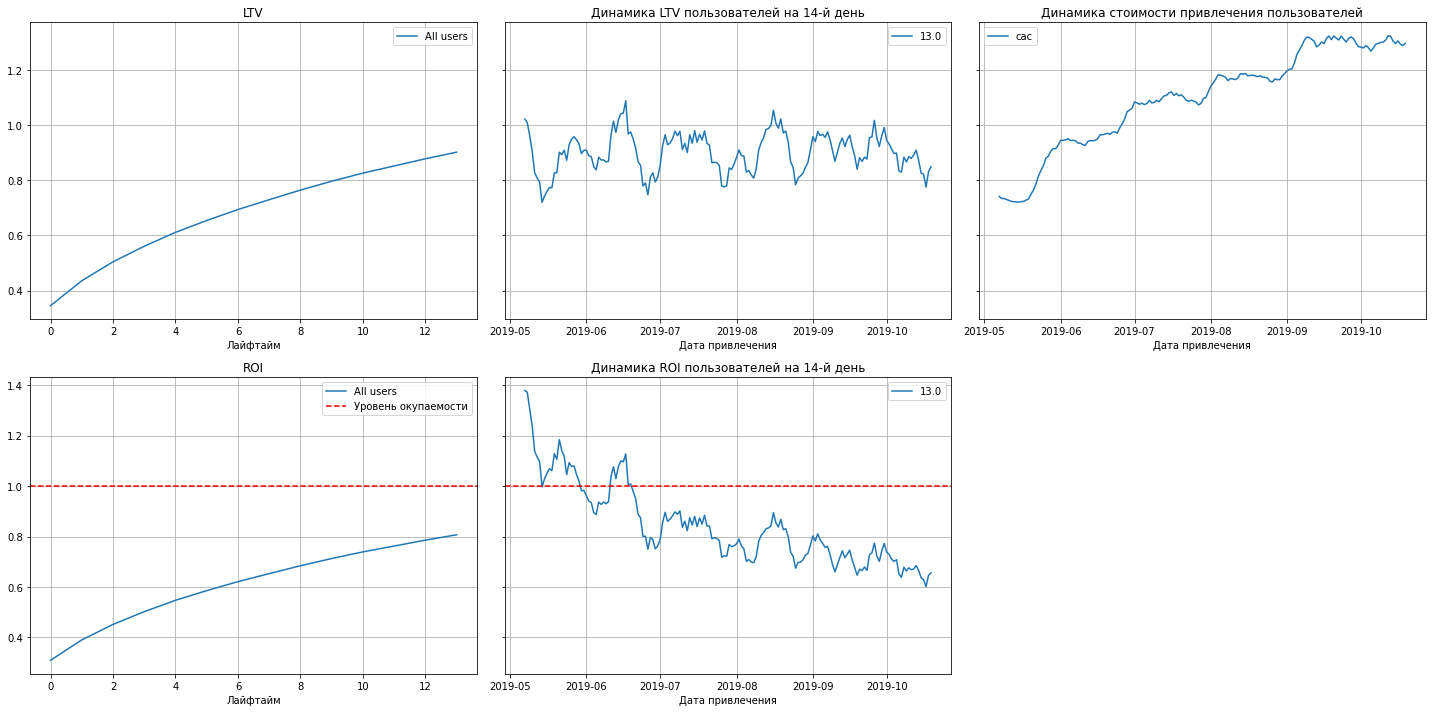

In [44]:
# задаём момент анализа
observation_date = datetime(2019, 11, 1).date() 

# задаём горизонт анализа
horizon_days = 14

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

 <b> Вывод: </b>
 
- Реклама не окупает себя. ROI в конце двух недель — 80%.
- CAC растёт, значит стоимость рекламного бюджета увеличивается.
- LTV  стабильно растёт, значит качество пользователей стабильное.

#### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

##### Конверсия и удержание с разбивкой по устройствам.

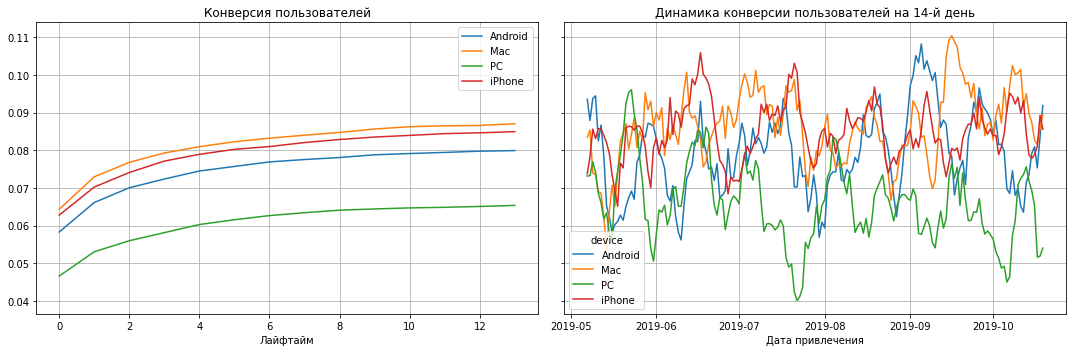

In [45]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

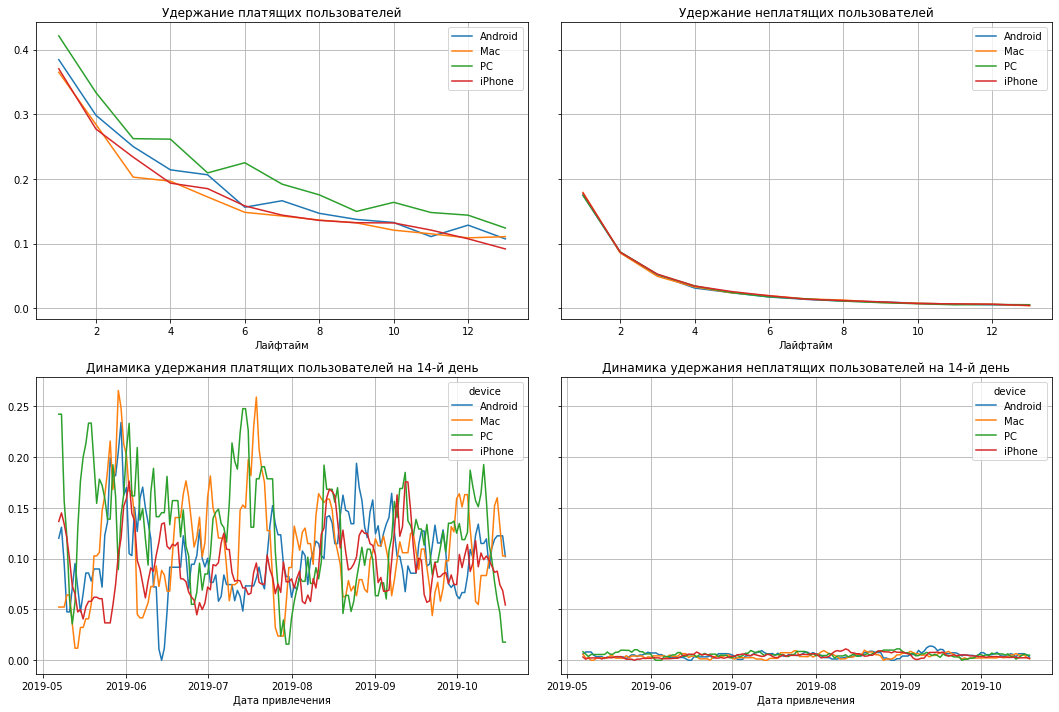

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

 <b> Вывод: </b>
 
 Конверсия у PC меньше всего. Удержание пользователей по платформам находятся примерно на одном уровне.

##### Конверсия и удержание с разбивкой по странам.

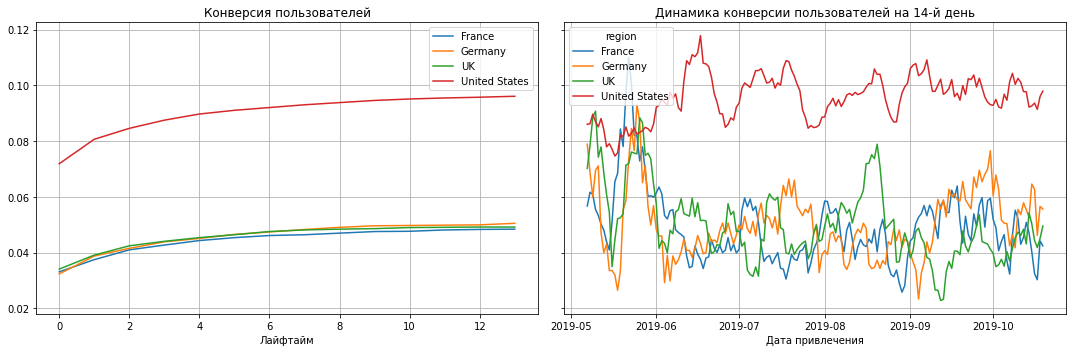

In [47]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

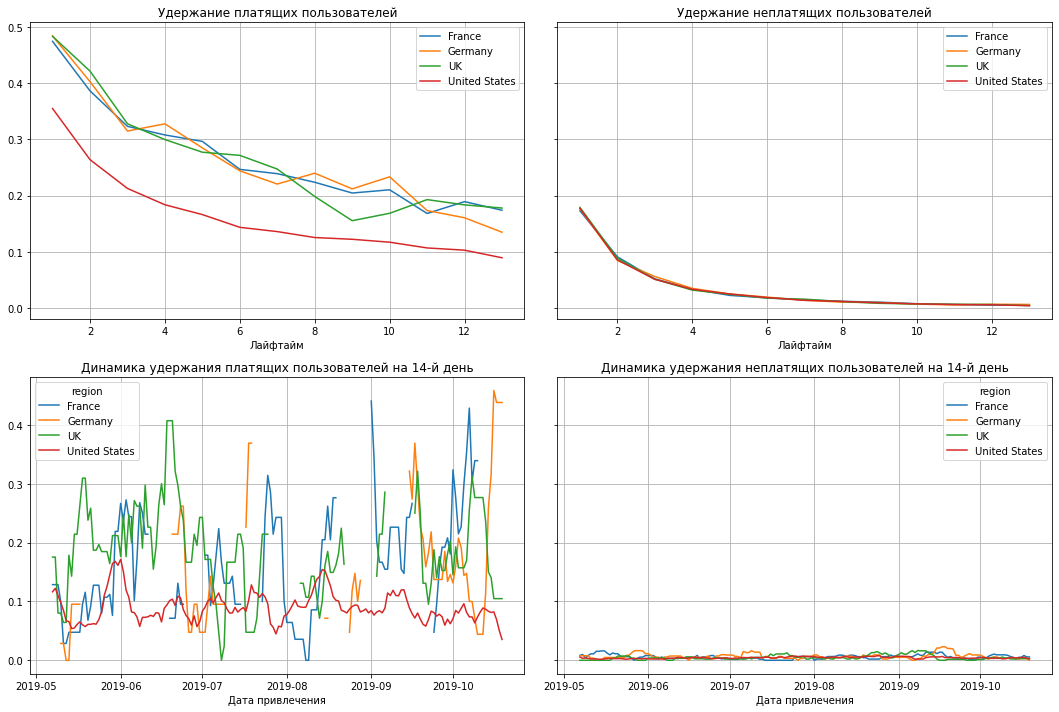

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

 <b> Вывод: </b>
 
Конверсия в США значительно выше, чем в других странах, но при этом удержание пользователей в США ниже, чем в других странах.

##### Конверсия и удержание с разбивкой по каналам.

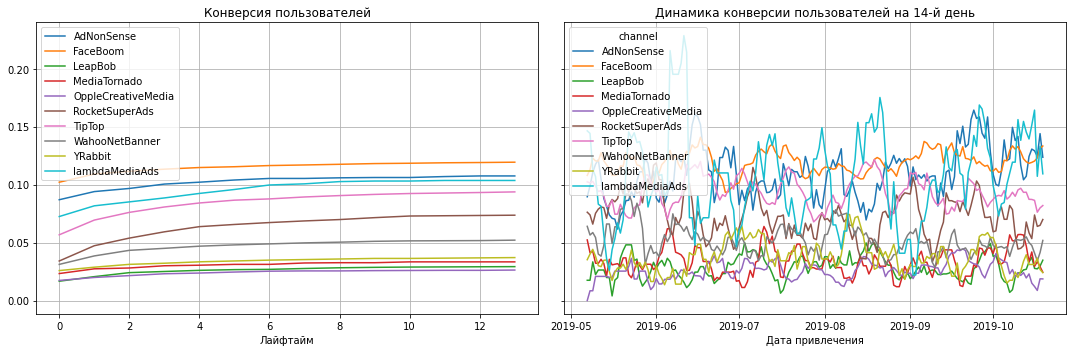

In [49]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

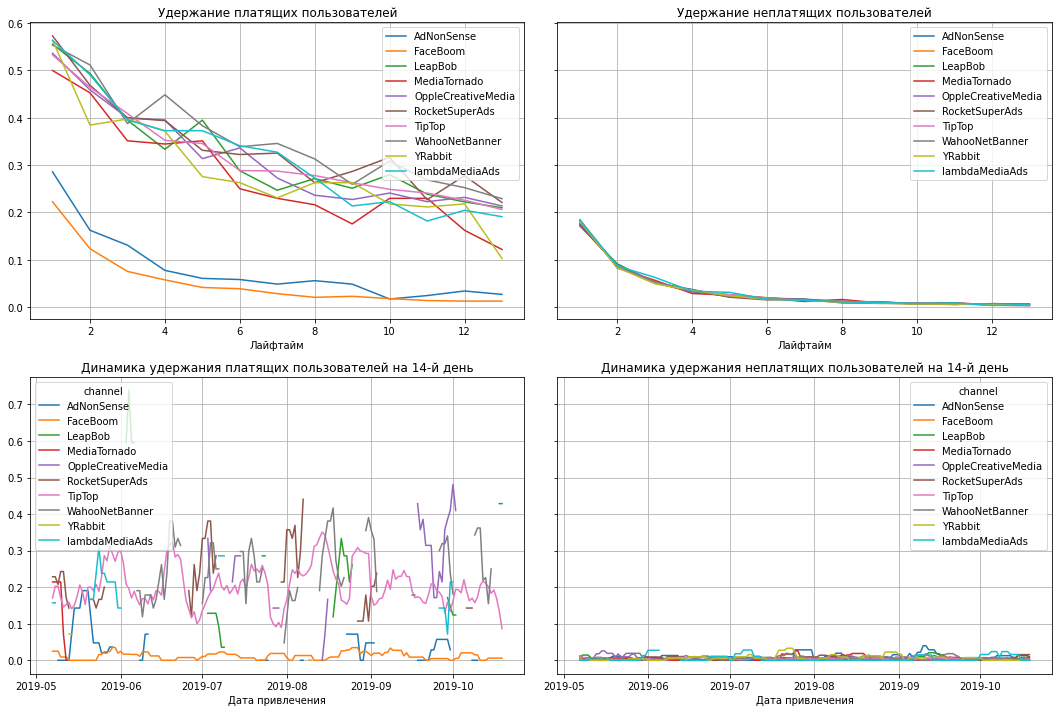

In [50]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

 <b> Вывод: </b>
 
Конверсия по всем каналам достаточно стабильная. Удержание пользователей меньше всего у платформы FaceBoom при самой высокой конверсии.

#### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

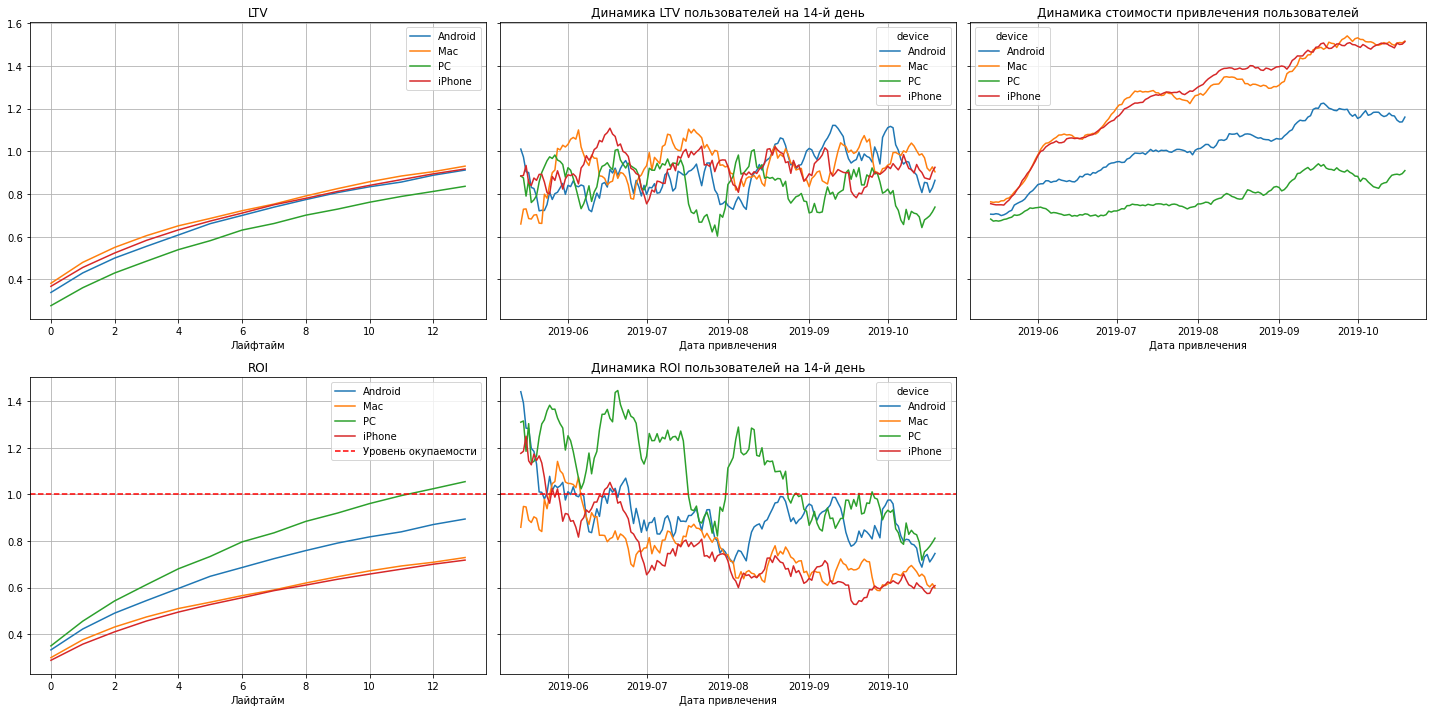

In [51]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

 <b> Вывод: </b>
 
- Реклама окупается только на PC.
- CAC растет на всех устройствах.
- LTV стабильно растёт везде.

#### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

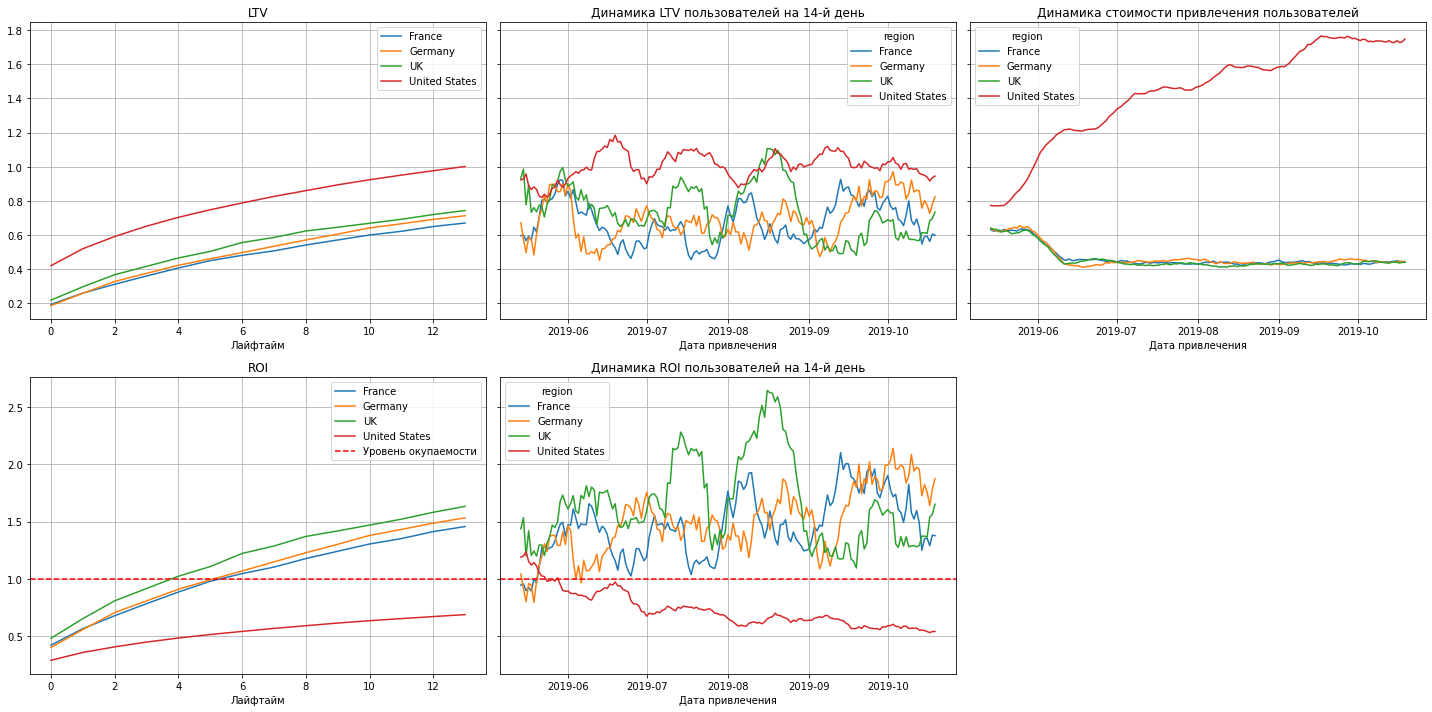

In [52]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

 <b> Вывод: </b>
 
- В США реклама не окупается, а в остальных странах окупаемость наступает на 6 день. 
- CAC в США растёт, а в остальных странах стабильно держится на невысоком уровне.
- LTV стабильно растёт везде.

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

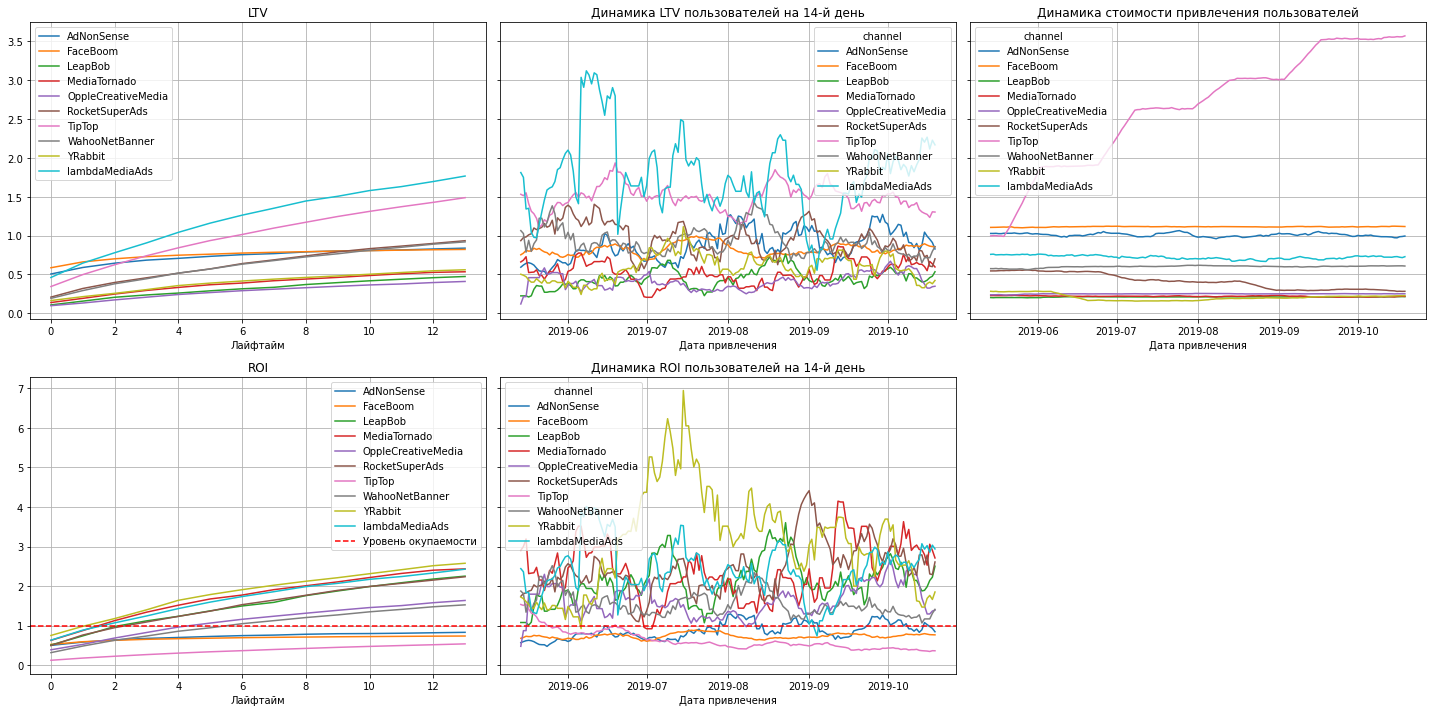

In [53]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

 <b> Вывод: </b>
 
- Реклама окупается по всем каналам, кроме TipTop, FaceBoom, AdNonSense. 
- CAC растёт только в TipTop, а на остальных каналах стабильно держится на невысоком уровне.
- LTV стабильно растёт везде.

 <b> Общий вывод по оценке окупаемости рекламы: </b>
 
Реклама не окупает себя. ROI в конце двух недель — 80%. Что касается разбивок:
- Реклама окупается только на PC.
- В США реклама не окупается, а в остальных странах окупаемость наступает на 6 день.
- Реклама окупается по всем каналам, кроме TipTop, FaceBoom, AdNonSense.

Стоимость рекламного бюджета увеличивается.
- CAC растет на всех устройствах.
- CAC в США растёт, а в остальных странах стабильно держится на невысоком уровне.
- CAC растёт только в TipTop, а на остальных каналах стабильно держится на невысоком уровне.

Так же, в целом, LTV стабильно растёт по всем показателям, значит качество пользователей стабильное.

### Вывод:

#### Причины неэффективности привлечения пользователей.

Общая сумма расходов на маркетинг с 1 мая по 27 октября 2019 года составила 105497.0.

Больше всего трат (порядка 80 %) пришлось на каналы TipTop и FaceBoom, при чём расходы на TipTop заметно росли, хотя и имели местами спады, а расходы FaceBoom (второго по затратности источника) начиная с июня застряли в коридоре 100 - 300 (в недельном выражении). Расходы на прочие каналы значительно меньше.

Дороже всего обходится привлечение пользователей через TipTop (2.799003). Следом идут FaceBoom (1.113286) и AdNonSense (1.008054).

Конверсия у PC меньше всего. Удержание пользователей по платформам находятся примерно на одном уровне.
Конверсия в США значительно выше, чем в других странах, но при этом удержание пользователей в США ниже, чем в других странах.
Конверсия по всем каналам достаточно стабильная. Удержание пользователей меньше всего у платформы FaceBoom при самой высокой конверсии.

Реклама не окупает себя. ROI в конце двух недель — 80%.
Реклама окупается только на PC.
Реклама окупается по всем каналам, кроме TipTop, FaceBoom, AdNonSense.
В США реклама не окупается, а в остальных странах окупаемость наступает на 6 день.

При этом CAC растёт, значит стоимость рекламного бюджета увеличивается.
CAC растет на всех устройствах.
CAC в США растёт, а в остальных странах стабильно держится на невысоком уровне.
CAC растёт только в TipTop, а на остальных каналах стабильно держится на невысоком уровне.

LTV стабильно растёт, значит качество пользователей стабильное.

#### Рекомендации для отдела маркетинга.

Следует обратить внимание на канал TipTop, т.к. стоимость привлечения пользователя здесь самая высокая, при этом на данном канале реклама себя не окупает.

Стоит обратить внимание на работу с рекламой в США, т.к. в США реклама себя не окупает.

Что касается устройств, здесь надо обратить внимание на владельцев Mac и iPhone, т.к. окупаемость отсутствует.